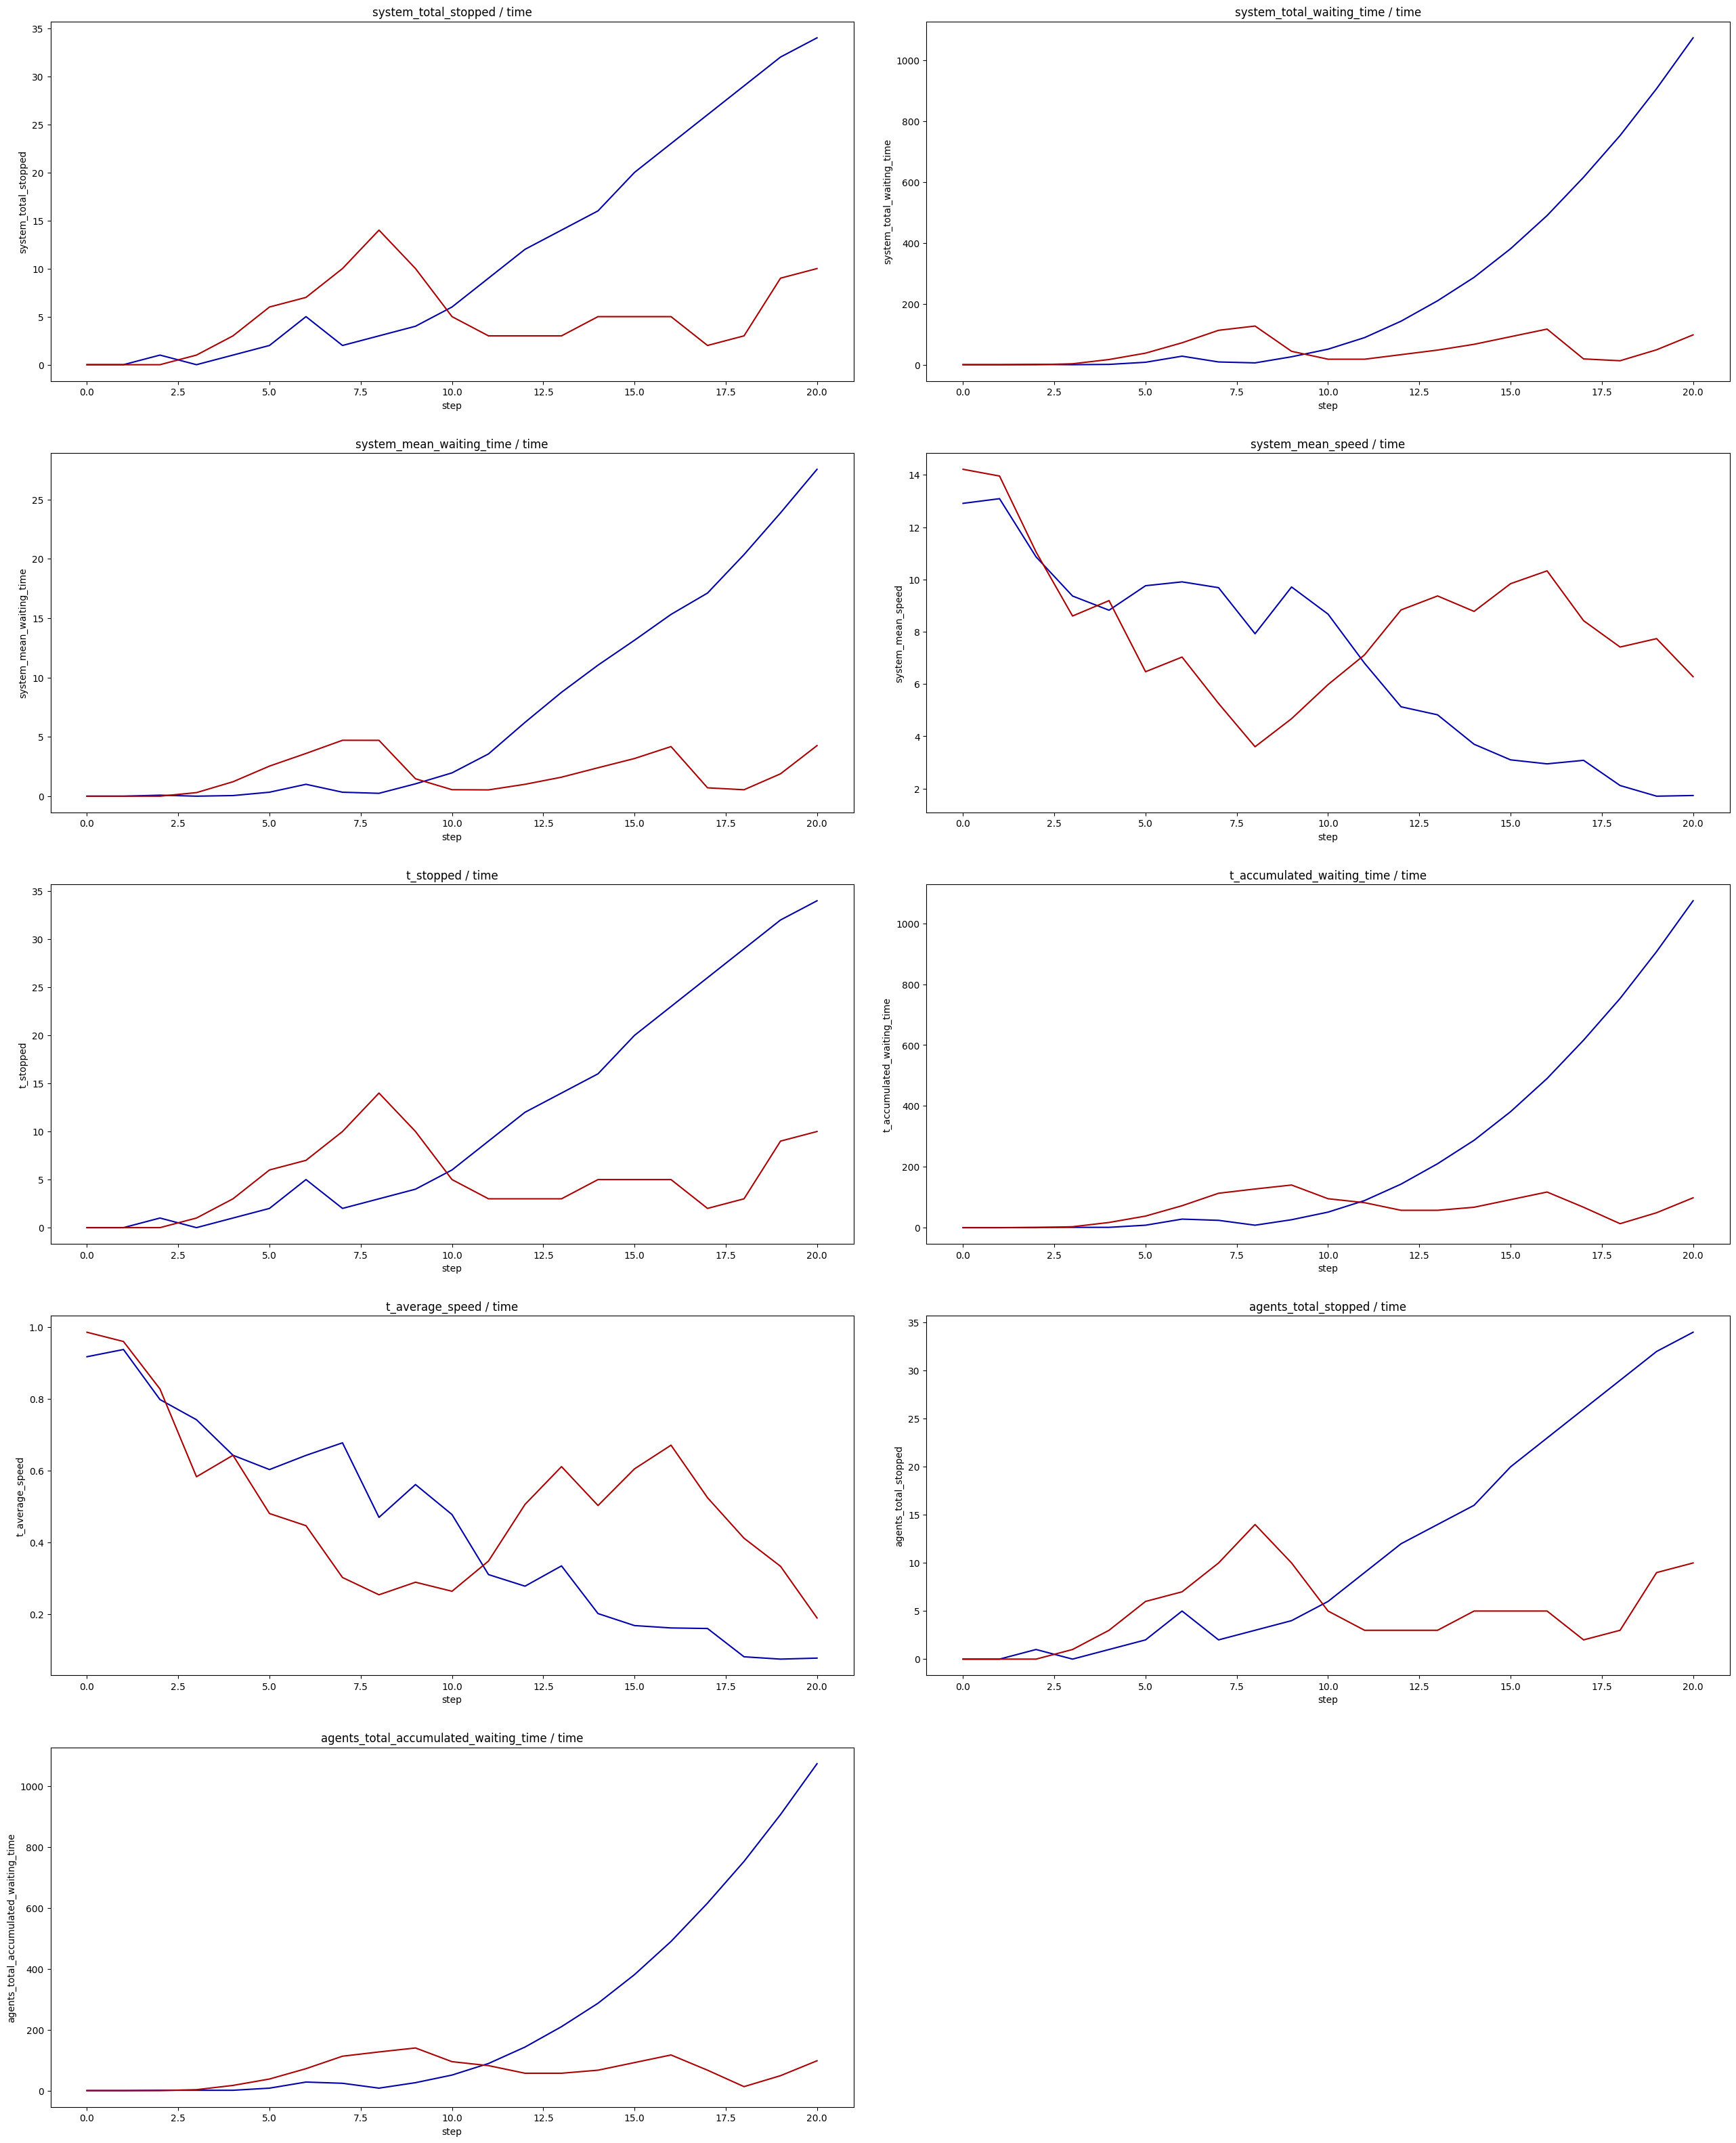

In [1]:
%matplotlib inline
from test2 import execution, agents

for agent in agents:
  execution(agent, agents[agent]['color'], agents[agent]['fixed'])